In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
import cv2
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l, semantic_sam_t
from segment_anything import build_sam
from tree_segmentation import  TreePredictor, TreeSegmentMetric, Tree2D, MaskData
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
import pycocotools.mask as mask_util
import networkx as nx

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)

2.0.0+cu117


In [3]:
data_root = Path('~/data/SA_1B_110').expanduser()
images_paths = list(data_root.glob('*.jpg'))
print(f"There are {len(images_paths)} images")
print(len(list(data_root.glob('*.json'))))

There are 11186 images
11186


In [4]:
def read_annotations(json_path: Path):
    masks = []
    scores = []
    with open(json_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']
    for ann in annotations:
        scores.append(ann['predicted_iou'])
        masks.append(mask_util.decode(ann['segmentation']))
    scores = np.stack(scores)
    masks = np.stack(masks)
    # return masks, scores
    tree2d = Tree2D(MaskData(masks=torch.from_numpy(masks), iou_preds=torch.from_numpy(scores)))
    tree2d.update_tree()
    return tree2d


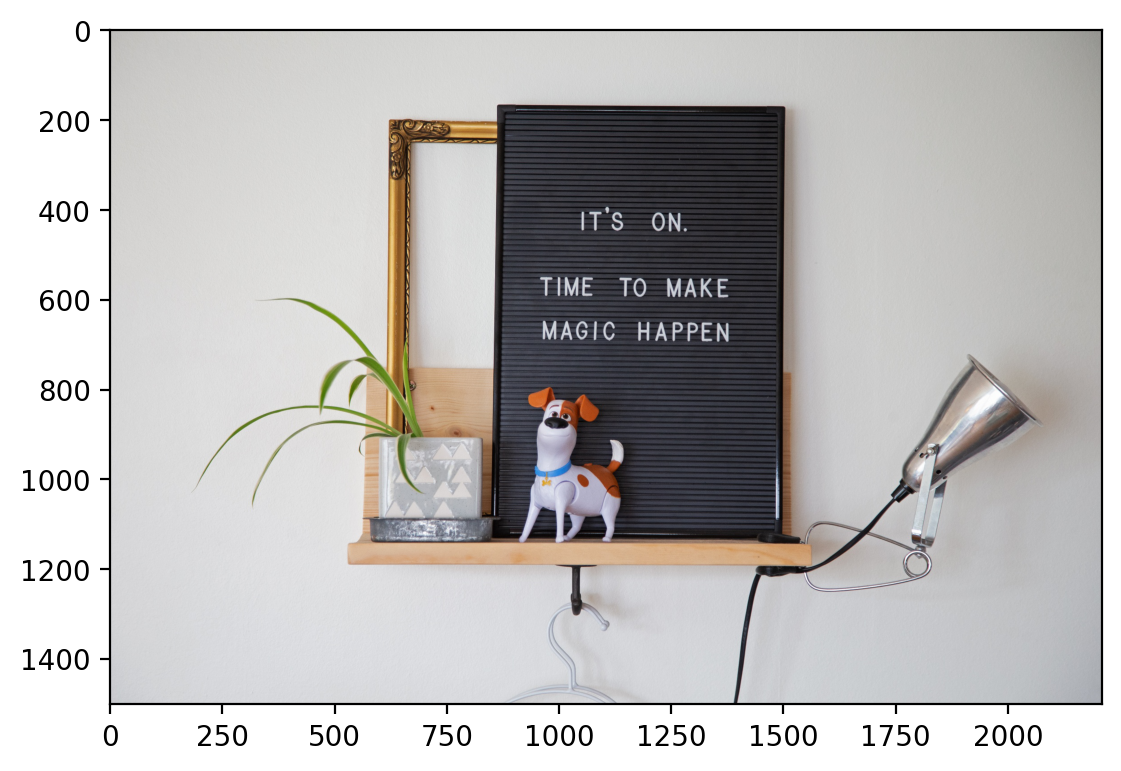

In [5]:
image_path = data_root.joinpath('sa_1231086.jpg')
image = utils.load_image(image_path)
plt.figure(dpi=200)
plt.imshow(image)

36


4

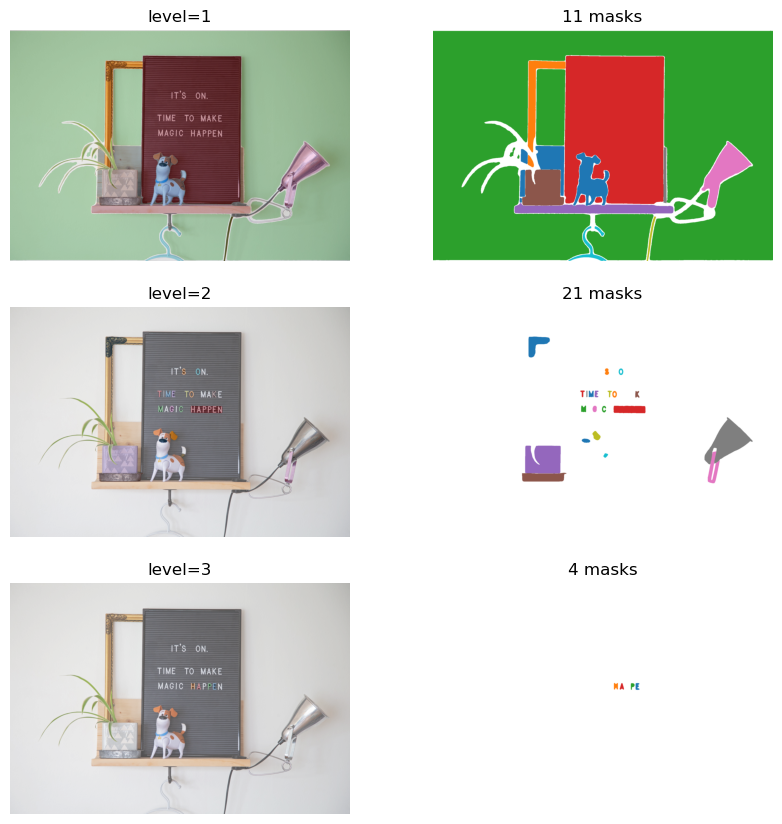

In [6]:
tree2d = read_annotations(image_path.with_suffix('.json'))
print(tree2d.cnt)
show_all_levels(image, tree2d)

In [47]:
save_dir = Path('./results/show_pics')
save_dir.mkdir(exist_ok=True)

for level, nodes in enumerate(tree2d.get_levels()):
    if level == 0:
        utils.save_image(save_dir.joinpath(f"0.png"), image)
        continue
    for x in nodes:
        x = x.item()
        mask = tree2d.masks[x-1]
        utils.save_image(save_dir.joinpath(f"{x}_{tree2d.parent[x].item()}.png"), mask.cpu().numpy()*255)
print(os.curdir)

.


1500 2210


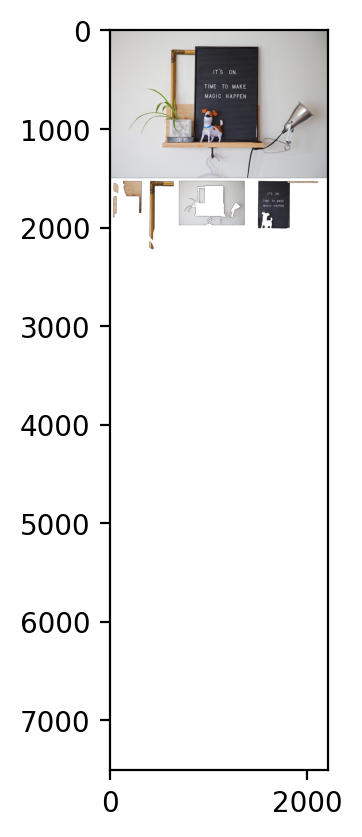

In [40]:
save_dir = Path('./results/show_pics')
save_dir.mkdir(exist_ok=True)

tree2d.node_rearrange()
H, W, C = image.shape 
final = np.zeros((H*5, W, 4), dtype=np.uint8)
final[:H,: , :C] = image
final[:H, :, -1] = 255
print(H, W)

def add_to_final(i, pos, scale=1.):
    mask = tree2d.masks[i].cpu().numpy().astype(np.uint8)*255
    masked_image = np.concatenate([image, mask[:, :, None]], axis=-1)
    row = np.any(mask, axis=0)
    col = np.any(mask, axis=1)
    # print(row.shape, col.shape)
    row = np.nonzero(row)[0]
    col = np.nonzero(col)[0]
    # print(row, col)
    top, down = row[0], row[-1]
    left, right = col[0], col[-1]
    # print(left, right, top, down)
    masked_image = masked_image[left:right+1, top:down+1]
    h, w, _ = masked_image.shape
    if scale != 1.:
        masked_image = cv2.resize(masked_image, (int(w*scale), int(h*scale)))
        h, w, _ = masked_image.shape
    final[pos[1]:pos[1]+h, pos[0]:pos[0]+w, :] = \
        np.where(masked_image[:, :, -1:]>0, masked_image, final[pos[1]:pos[1]+h, pos[0]:pos[0]+w, :])

for level, nodes in enumerate(tree2d.get_levels()):
    if level == 0:
        continue
    if level == 1:
        add_to_final(0, (30, H+30))
        add_to_final(1, (400, H+30))
        add_to_final(2, (700, H+30), 0.3)
        add_to_final(3, (1500, H+30), 0.5)
        add_to_final(4, (1800, H+30), 0.3)

    
plt.figure(dpi=200)
plt.imshow(final)

In [42]:
print(' & '.join(str(v) for v in utils.eval_str("{SQ: 0.6104, RQ: 0.8370, PQ: 0.5081, TS: 0.9971, TQ: 0.5060, mSQ: 0.9195, mRQ: 0.4078, mPQ: 0.3736, mTS: 0.9983, mTQ: 0.3729, mIoU: 0.6078}").values()))

0.6104 & 0.837 & 0.5081 & 0.9971 & 0.506 & 0.9195 & 0.4078 & 0.3736 & 0.9983 & 0.3729 & 0.6078


In [11]:
# load SAM
assert torch.cuda.is_available()
# model = build_sam(Path('./weights/sam_vit_h_4b8939.pth').expanduser())
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model, box_nms_thresh=0.7, pred_iou_thresh=0.7)

In [8]:
H, W, _ = image.shape 
scale = min(1024/H, 1024/W)
image = cv2.resize(image, (int(W*scale), int(H*scale)), interpolation=cv2.INTER_AREA)
print(image.shape)

(695, 1024, 3)


In [12]:
prediction = tree_seg.tree_generate(image, verbose=1)

[Tree] reset
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 47 to 43
[Tree2D] complete init segmentation
[Tree] Resize tree from 43 to 44
[Tree] Resize tree from 44 to 45
[Tree] Resize tree from 45 to 46
[Tree2D] Try to insert 25 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 46 to 46
[Tree2D] complete step 0 update segmentation
[Tree] Resize tree from 46 to 47
[Tree] Resize tree from 47 to 48
[Tree2D] Try to insert 22 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 48 to 48
[Tree2D] complete step 1 update segmentation
[Tree] Resize tree from 48 to 49
[Tree] Resize tree from 49 to 50
[Tree2D] Try to insert 21 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 50 to 50
[Tree2D] complete step 2 update segmentation
[Tree] Resize tree from 50 to 51
[Tree] Resize tree from 51 to 52
[Tree] Resize tree from 52 to 53
[Tree] Resize tre

[Tree2D] uncompress masks


5

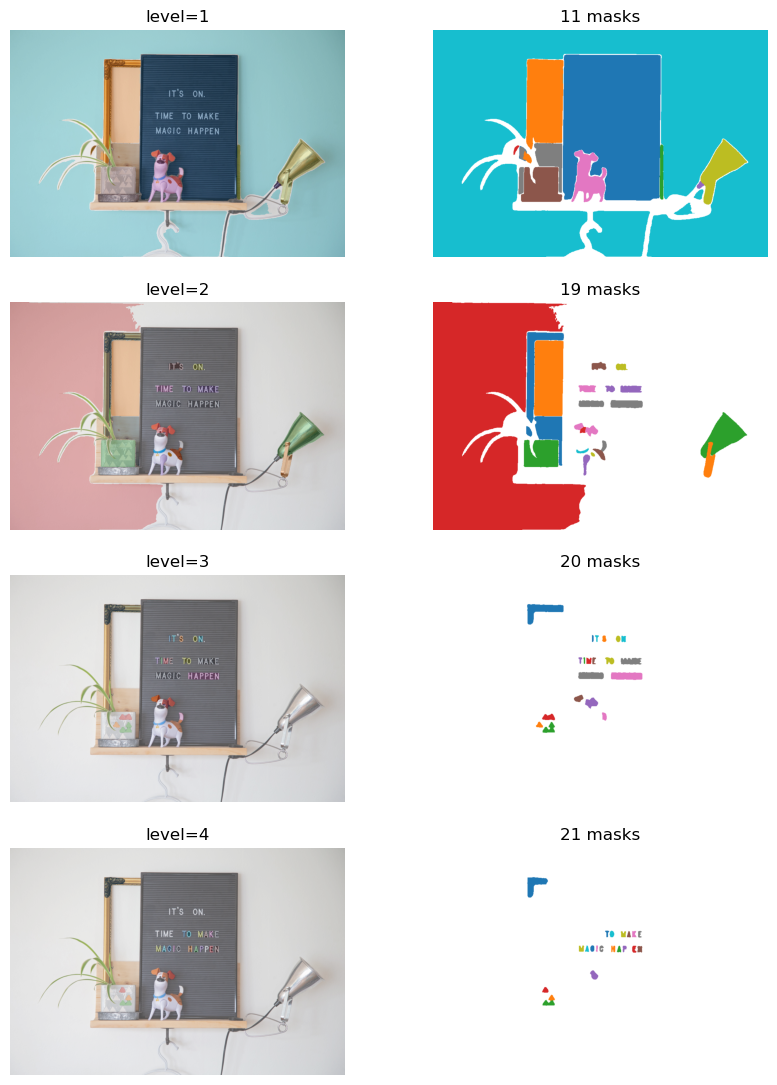

In [13]:
show_all_levels(image, prediction)

In [9]:
def get_cropped(image:Tensor, mask:Tensor):
    # print(utils.show_shape(image, mask))
    mask = mask.cpu().numpy() if isinstance(mask, Tensor) else mask
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)    
    image = image.cpu().numpy() if isinstance(image, Tensor) else image
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)    
    masked_image = np.concatenate([image, mask], axis=-1)
    row = np.any(mask, axis=0)
    col = np.any(mask, axis=1)
    # print(row.shape, col.shape)
    row = np.nonzero(row)[0]
    col = np.nonzero(col)[0]
    # print(row, col)
    top, down = row[0], row[-1]
    left, right = col[0], col[-1]
    # print(left, right, top, down)
    masked_image = masked_image[left:right+1, top:down+1]
    return masked_image

[0, 36, 25, 24, 23, 22, 21, 19, 16, 13, 7, 5, 2, 35, 33, 32, 31, 30, 28, 27, 26, 1, 9, 10, 12, 20, 6, 8, 15, 17, 34, 14, 3, 29, 4, 11, 18]
[(0, 36), (0, 25), (0, 24), (0, 23), (0, 22), (0, 21), (0, 19), (0, 16), (0, 13), (0, 7), (0, 5), (25, 2), (23, 35), (23, 33), (23, 32), (23, 31), (23, 30), (23, 28), (23, 27), (23, 26), (23, 1), (23, 9), (23, 10), (23, 12), (23, 20), (21, 6), (21, 8), (19, 15), (19, 17), (5, 34), (5, 14), (5, 3), (20, 29), (20, 4), (20, 11), (20, 18)]
[-0.8805 -0.8807]
[0.9525 1.    ]


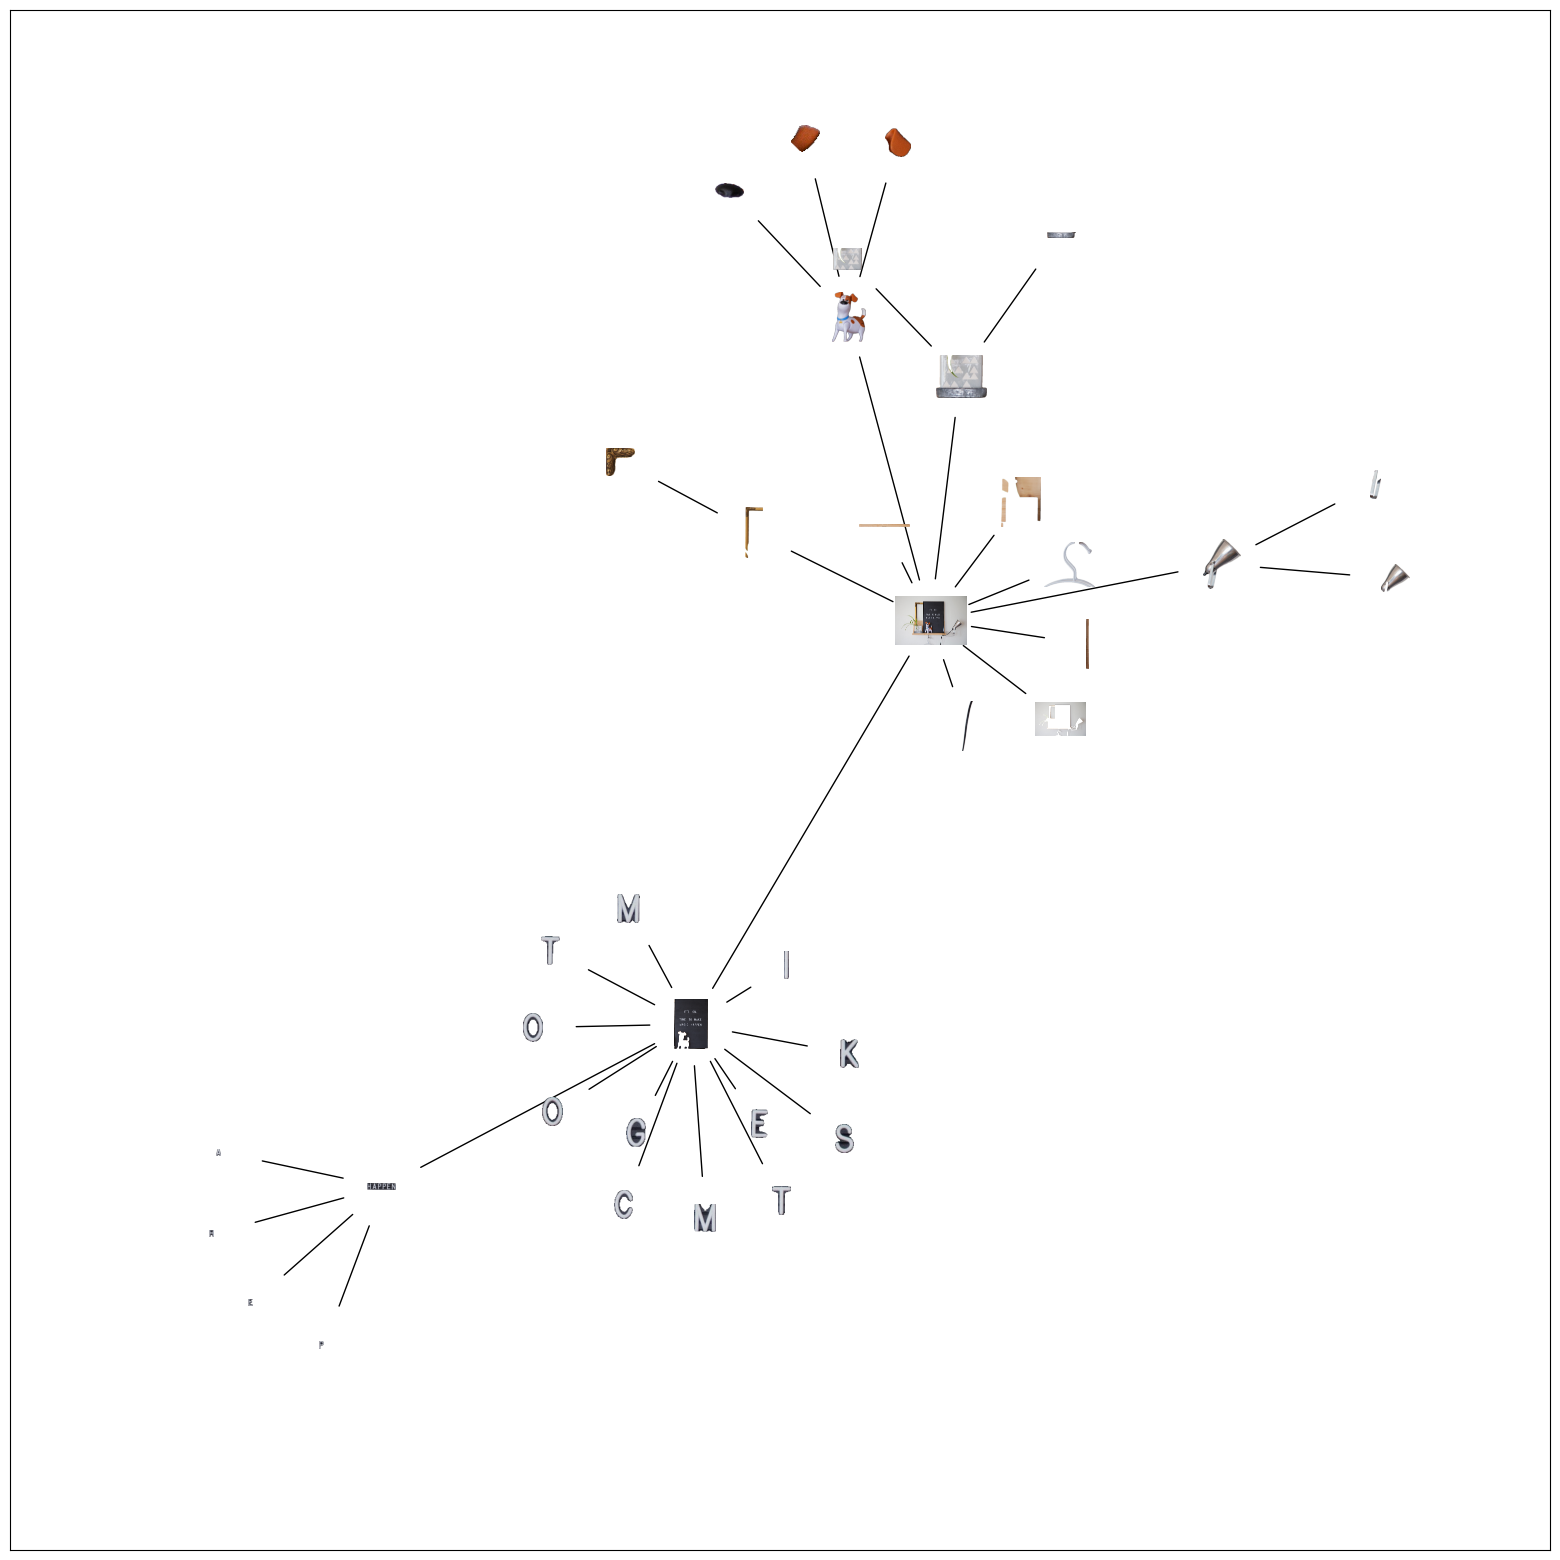

In [41]:
G = nx.Graph()

for level_no, nodes in enumerate(tree2d.get_levels()):
    for x in nodes:
        x = x.item()
        G.add_node(x, level=level_no)
        if x != 0:
            G.add_edge(x, tree2d.parent[x].item())

print(G.nodes())
print(G.edges())
# pos = nx.circular_layout(G)
# pos = nx.multipartite_layout(G)
pos = nx.spring_layout(G)
# pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root=None, args="")
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(111)
# ax = fig.add_axes([0, 0, 1, 1])
ax.set_aspect('equal')
# nx.draw_networkx_edges(G, pos, ax=ax)
print(np.min(np.stack(list(pos.values())), axis=0))
print(np.max(np.stack(list(pos.values())), axis=0))
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax=ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=30,
    min_target_margin=30,
)

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.015
icon_center = icon_size / 2.0

# Add the respective image to each node
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    level = G.nodes[n]['level']
    img = image if n == 0 else get_cropped(image, tree2d.masks[n - 1, :, :, None].bool().cpu())
    size = icon_size * (1 - 0.3 * level)
    a = plt.axes([xa - size * 0.5, ya - size * 0.5, size, size])
    a.set_aspect('equal')
    a.imshow(img)
    a.axis("off")
plt.show()